In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('hand_landmarks_data.csv')
df.head()

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,...,x19,y19,z19,x20,y20,z20,x21,y21,z21,label
0,262.669968,257.304901,-3.649205e-07,257.417542,247.109055,0.004224,246.882957,241.716827,0.005798,236.384537,...,223.345093,255.490692,-0.020450,215.043365,258.114746,-0.024577,208.006393,259.608673,-0.026722,call
1,83.351778,346.059113,-2.345265e-07,81.925037,328.562347,-0.011102,90.080132,311.535248,-0.021096,95.641823,...,132.451618,341.794434,-0.038175,142.773582,342.829254,-0.037336,152.431698,343.015991,-0.036136,call
2,187.756977,260.235492,-2.417307e-07,195.460579,241.506035,-0.000184,207.259529,223.674339,-0.009687,215.413628,...,250.301010,268.602938,-0.044068,262.425133,271.276638,-0.040469,272.989952,272.272231,-0.038301,call
3,114.976696,331.594238,-1.233261e-07,114.503494,320.549957,-0.002824,116.636627,310.080994,-0.008911,117.685066,...,145.195450,329.357544,-0.027622,151.053200,329.712341,-0.027863,155.990364,329.548828,-0.027723,call
4,188.795288,141.727867,-1.622995e-07,188.520905,127.947464,-0.002884,191.982880,111.010563,-0.008115,192.552521,...,226.696396,132.263248,-0.025113,234.831741,130.684147,-0.024087,241.587769,128.477188,-0.023486,call


In [4]:
print(df.shape)
print(df['label'].value_counts())

(25675, 64)
label
three2             1653
palm               1649
four               1634
ok                 1592
stop_inverted      1567
call               1506
peace_inverted     1497
stop               1482
rock               1458
three              1456
peace              1441
like               1436
two_up_inverted    1371
two_up             1343
dislike            1295
one                1263
mute               1087
fist                945
Name: count, dtype: int64


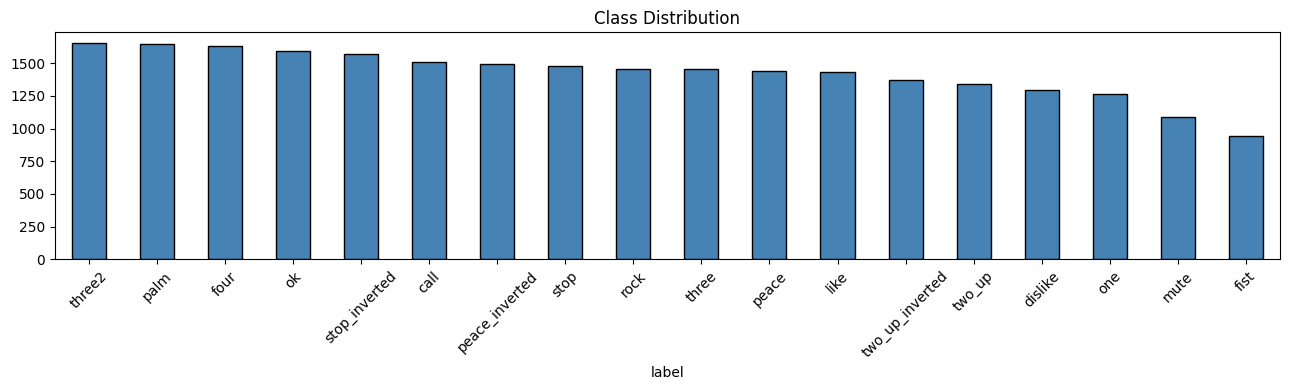

In [5]:
df['label'].value_counts().plot(kind='bar', figsize=(13, 4), color='steelblue', edgecolor='black')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('class_distribution.png', dpi=150)
plt.show()

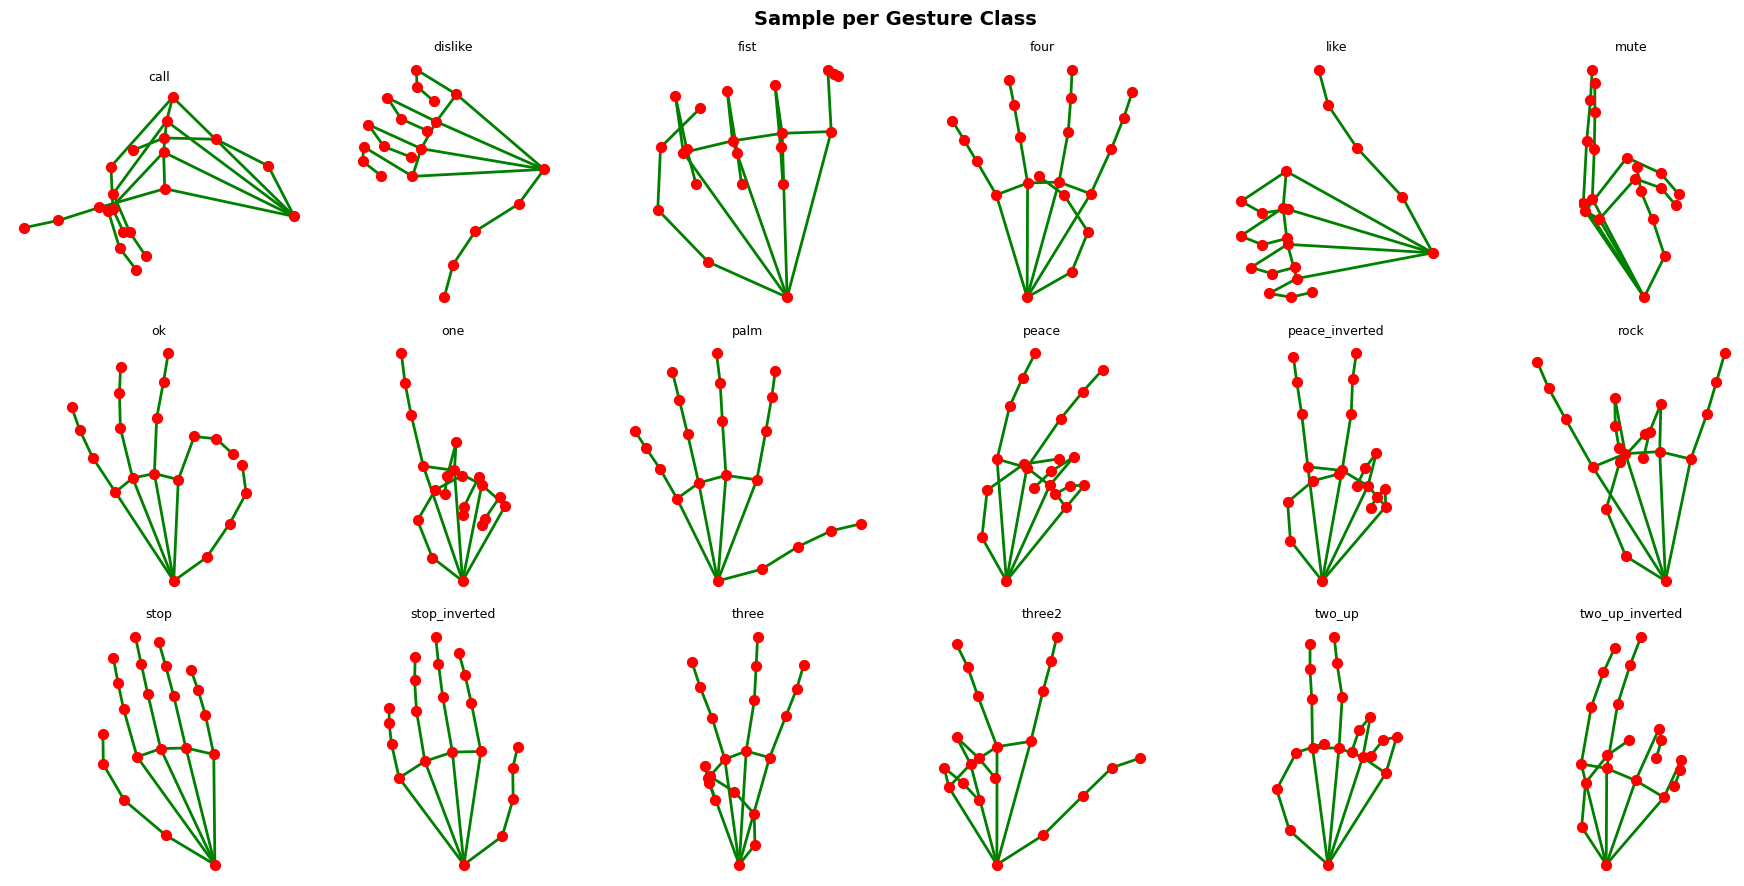

In [6]:
HAND_CONNECTIONS = [
    (0,1),(1,2),(2,3),(3,4),
    (0,5),(5,6),(6,7),(7,8),
    (0,9),(9,10),(10,11),(11,12),
    (0,13),(13,14),(14,15),(15,16),
    (0,17),(17,18),(18,19),(19,20),
    (5,9),(9,13),(13,17)
]

def plot_hand(row, title='', ax=None):
    show = ax is None
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 4))
    x = [row[f'x{i}'] for i in range(1, 22)]
    y = [row[f'y{i}'] for i in range(1, 22)]
    for a, b in HAND_CONNECTIONS:
        ax.plot([x[a], x[b]], [y[a], y[b]], 'g-', linewidth=2)
    ax.scatter(x, y, c='red', s=50, zorder=2)
    ax.set_title(title, fontsize=9)
    ax.set_aspect('equal')
    ax.invert_yaxis()
    ax.axis('off')
    if show:
        plt.tight_layout()
        plt.show()

gesture_classes = sorted(df['label'].unique())
cols = 6
rows = (len(gesture_classes) + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
axes = axes.flatten()

for i, g in enumerate(gesture_classes):
    sample = df[df['label'] == g].iloc[0]
    plot_hand(sample, title=g, ax=axes[i])

for j in range(len(gesture_classes), len(axes)):
    axes[j].axis('off')

plt.suptitle('Sample per Gesture Class', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('hand_landmarks_per_class.png', dpi=150)
plt.show()

In [7]:
def normalize(df):
    df = df.copy()
    for idx in df.index:
        wx, wy = df.loc[idx, 'x1'], df.loc[idx, 'y1']
        for i in range(1, 22):
            df.loc[idx, f'x{i}'] -= wx
            df.loc[idx, f'y{i}'] -= wy
        scale = np.sqrt(df.loc[idx, 'x13']**2 + df.loc[idx, 'y13']**2)
        if scale > 1e-6:
            for i in range(1, 22):
                df.loc[idx, f'x{i}'] /= scale
                df.loc[idx, f'y{i}'] /= scale
    return df

df_norm = normalize(df)
df_norm.dropna(inplace=True)
df_norm.reset_index(drop=True, inplace=True)

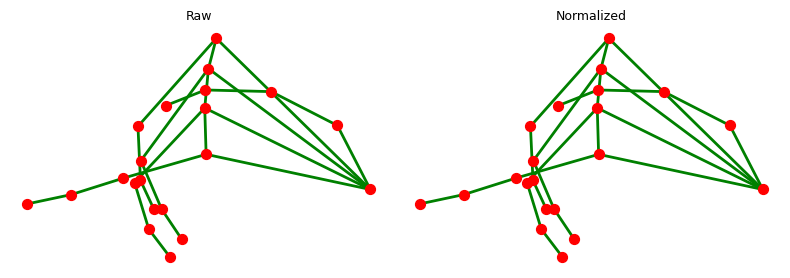

In [8]:
sample_idx = df[df['label'] == gesture_classes[0]].index[0]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
plot_hand(df.loc[sample_idx], title='Raw', ax=ax1)
plot_hand(df_norm.loc[sample_idx], title='Normalized', ax=ax2)
plt.tight_layout()
plt.savefig('normalization_comparison.png', dpi=150)
plt.show()

In [9]:
feature_cols = [c for c in df_norm.columns if c != 'label']
X = df_norm[feature_cols].values

le = LabelEncoder()
y = le.fit_transform(df_norm['label'])
class_names = le.classes_

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

In [10]:
import time

def train_eval(name, model, Xtr, ytr, Xte, yte):
    t = time.time()
    model.fit(Xtr, ytr)
    pred = model.predict(Xte)
    return {
        'Model':     name,
        'Accuracy':  accuracy_score(yte, pred),
        'Precision': precision_score(yte, pred, average='weighted', zero_division=0),
        'Recall':    recall_score(yte, pred, average='weighted', zero_division=0),
        'F1':        f1_score(yte, pred, average='weighted', zero_division=0),
        'Time':      round(time.time() - t, 2),
        '_pred':     pred,
        '_model':    model,
    }

results = []
preds = {}

rf  = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
svm = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)
knn = KNeighborsClassifier(n_neighbors=7, weights='distance', n_jobs=-1)
mlp = MLPClassifier(hidden_layer_sizes=(256, 128, 64), max_iter=300, random_state=42, early_stopping=True)

for name, model, Xtr, Xte in [
    ('Random Forest', rf,  X_train,    X_test),
    ('SVM',           svm, X_train_sc, X_test_sc),
    ('KNN',           knn, X_train_sc, X_test_sc),
    ('MLP',           mlp, X_train_sc, X_test_sc),
]:
    r = train_eval(name, model, Xtr, y_train, Xte, y_test)
    results.append(r)
    preds[name] = r['_pred']
    print(f"{name}: Acc={r['Accuracy']:.4f}, F1={r['F1']:.4f}, Time={r['Time']}s")

Random Forest: Acc=0.9792, F1=0.9792, Time=6.62s
SVM: Acc=0.9698, F1=0.9699, Time=7.44s
KNN: Acc=0.9369, F1=0.9370, Time=1.75s
MLP: Acc=0.9875, F1=0.9875, Time=11.04s


In [11]:
keys = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']
results_df = pd.DataFrame([{k: r[k] for k in keys} for r in results])
results_df = results_df.sort_values('F1', ascending=False).reset_index(drop=True)
results_df

,Model,Accuracy,Precision,Recall,F1,Time
0,MLP,0.987537,0.987673,0.987537,0.987550,11.04
1,Random Forest,0.979163,0.979361,0.979163,0.979208,6.62
2,SVM,0.969815,0.970271,0.969815,0.969870,7.44
3,KNN,0.936904,0.937804,0.936904,0.936980,1.75


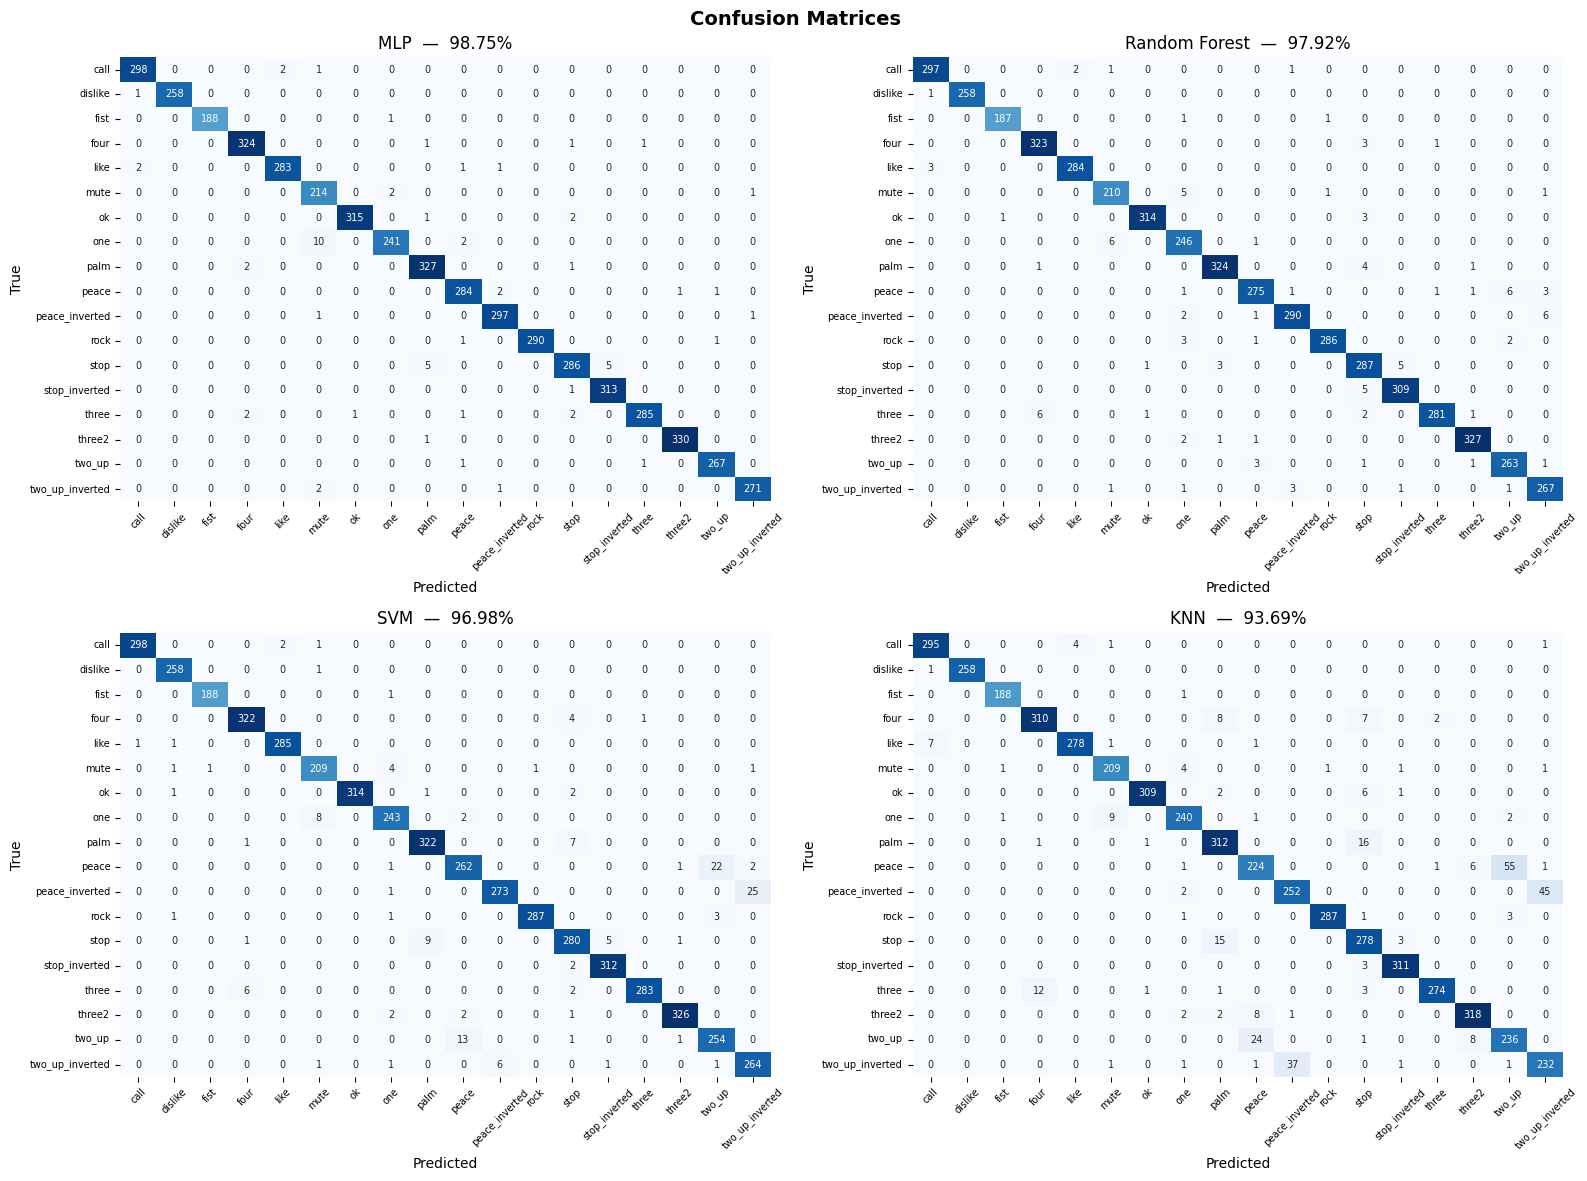

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
for ax, name in zip(axes.flatten(), results_df['Model']):
    cm = confusion_matrix(y_test, preds[name])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                ax=ax, cbar=False, annot_kws={'size': 7})
    ax.set_title(f'{name}  —  {accuracy_score(y_test, preds[name]):.2%}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.tick_params(axis='x', rotation=45, labelsize=7)
    ax.tick_params(axis='y', rotation=0, labelsize=7)
plt.suptitle('Confusion Matrices', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=150)
plt.show()

In [13]:
best_name = results_df.iloc[0]['Model']
print(f'Best model: {best_name}')
print(classification_report(y_test, preds[best_name], target_names=class_names, zero_division=0))

Best model: MLP
                 precision    recall  f1-score   support

           call       0.99      0.99      0.99       301
        dislike       1.00      1.00      1.00       259
           fist       1.00      0.99      1.00       189
           four       0.99      0.99      0.99       327
           like       0.99      0.99      0.99       287
           mute       0.94      0.99      0.96       217
             ok       1.00      0.99      0.99       318
            one       0.99      0.95      0.97       253
           palm       0.98      0.99      0.98       330
          peace       0.98      0.99      0.98       288
 peace_inverted       0.99      0.99      0.99       299
           rock       1.00      0.99      1.00       292
           stop       0.98      0.97      0.97       296
  stop_inverted       0.98      1.00      0.99       314
          three       0.99      0.98      0.99       291
         three2       1.00      1.00      1.00       331
         two_u

In [ ]:
import os
import joblib
import datetime
import csv
from collections import deque
from IPython.display import display
import ipywidgets as widgets
import numpy as np

# Ensure MediaPipe and OpenCV are available
try:
    import cv2
    import mediapipe as mp
except Exception as e:
    raise ImportError('cv2/mediapipe import failed. Please install opencv-python and mediapipe.') from e

# Try to load saved model(s) from ./models if available
models_dir = 'models'
best_clf = globals().get('best_clf', None)
scaler = globals().get('scaler', None)
le = globals().get('le', None)
class_names = globals().get('class_names', None)
if os.path.isdir(models_dir):
    files = [f for f in os.listdir(models_dir) if f.endswith('.pkl')]
    if files and best_clf is None:
        # prefer file with best_name if present
        pref = None
        try:
            pref = f"{best_name.replace(' ', '_')}.pkl"
        except Exception:
            pref = None
        chosen = pref if pref and pref in files else files[0]
        try:
            best_clf = joblib.load(os.path.join(models_dir, chosen))
            print('Loaded classifier from', chosen)
        except Exception as e:
            print('Failed to load classifier:', e)
    if scaler is None:
        sfile = os.path.join(models_dir, 'scaler.pkl')
        if os.path.exists(sfile):
            try:
                scaler = joblib.load(sfile)
                print('Loaded scaler')
            except Exception:
                scaler = None
    if le is None:
        lfile = os.path.join(models_dir, 'label_encoder.pkl')
        if os.path.exists(lfile):
            try:
                le = joblib.load(lfile)
                class_names = le.classes_
                print('Loaded label encoder')
            except Exception:
                le = None

use_scale = scaler is not None

def normalize_realtime(lms):
    # lms: list of (x,y,z) tuples from mediapipe landmarks
    arr = np.array([[p[0], p[1], p[2]] for p in lms], dtype=np.float32)
    arr[:, 0] -= arr[0, 0]
    arr[:, 1] -= arr[0, 1]
    scale = np.sqrt(arr[12, 0]**2 + arr[12, 1]**2)
    if scale > 1e-6:
        arr[:, 0] /= scale
        arr[:, 1] /= scale
    feat = np.concatenate([arr[:, 0], arr[:, 1]])
    return feat

def process_video(input_path, output_path, window=10):
    mp_hands = mp.solutions.hands
    mp_draw  = mp.solutions.drawing_utils
    cap = cv2.VideoCapture(input_path)
    if not cap.isOpened():
        raise IOError('Cannot open video: ' + input_path)
    fps    = cap.get(cv2.CAP_PROP_FPS) or 30.0
    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)) or 640
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)) or 480
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    buf = deque(maxlen=window)

    with mp_hands.Hands(max_num_hands=1, min_detection_confidence=0.5) as hands:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            res = hands.process(rgb)
            label = ''
            if res.multi_hand_landmarks:
                lms = [(lm.x, lm.y, lm.z) for lm in res.multi_hand_landmarks[0].landmark]
                feat = normalize_realtime(lms).reshape(1, -1)
                if use_scale:
                    feat = scaler.transform(feat)
                pred = best_clf.predict(feat)[0]
                buf.append(pred)
                # majority vote
                from scipy import stats as scipy_stats
                label_idx = scipy_stats.mode(list(buf), keepdims=True).mode[0]
                try:
                    label = class_names[label_idx] if class_names is not None else str(label_idx)
                except Exception:
                    label = str(label_idx)
                mp_draw.draw_landmarks(frame, res.multi_hand_landmarks[0], mp_hands.HAND_CONNECTIONS)
            cv2.rectangle(frame, (0, 0), (300, 45), (0, 0, 0), -1)
            cv2.putText(frame, label, (10, 32), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            out.write(frame)
    cap.release()
    out.release()
    print(f'Saved output to {output_path}')
    # append log
    log_file = 'processed_videos.csv'
    ts = datetime.datetime.now().isoformat()
    with open(log_file, 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([ts, input_path, output_path])
    return output_path

# Upload widget and processing button
uploader = widgets.FileUpload(accept='video/*', multiple=False)
display(uploader)

def _process_upload(b):
    if not uploader.value:
        print('No file uploaded yet.')
        return
    for name, info in uploader.value.items():
        data = info['content'] if isinstance(info, dict) else info
        os.makedirs('uploads', exist_ok=True)
        in_path = os.path.join('uploads', name)
        with open(in_path, 'wb') as fh:
            fh.write(data)
        out_path = os.path.splitext(in_path)[0] + '_out.mp4'
        print('Processing', in_path)
        try:
            process_video(in_path, out_path)
            print('Processing complete. Output:', out_path)
        except Exception as e:
            print('Processing failed:', e)

btn = widgets.Button(description='Process uploaded video')
btn.on_click(_process_upload)
display(btn)

print('Upload a video using the widget above, then click the button to process.')